Task 0: Node 1 | Start 0.00s | End 1.20s
Task 1: Node 1 | Start 1.20s | End 2.20s
Task 2: Node 0 | Start 2.00s | End 3.75s
Task 3: Node 1 | Start 2.20s | End 3.00s
Task 4: Node 1 | Start 4.55s | End 5.15s
Task 5: Node 1 | Start 5.15s | End 5.55s
Makespan = 5.554 s, Energy = 27.559 J


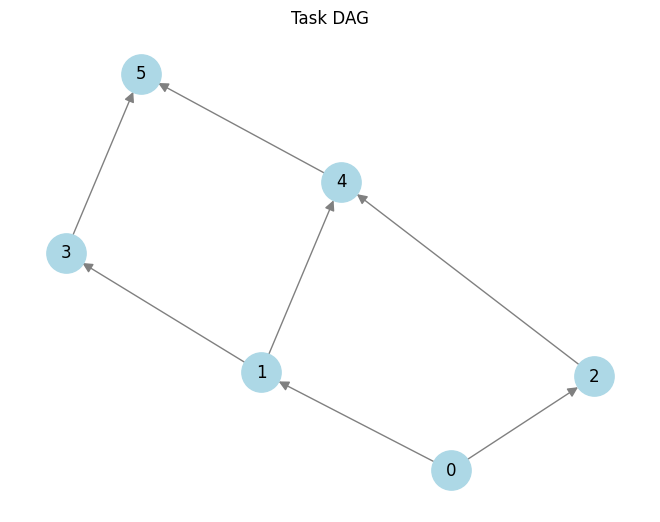

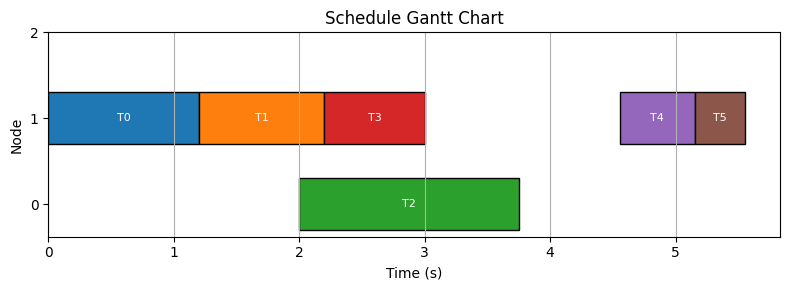

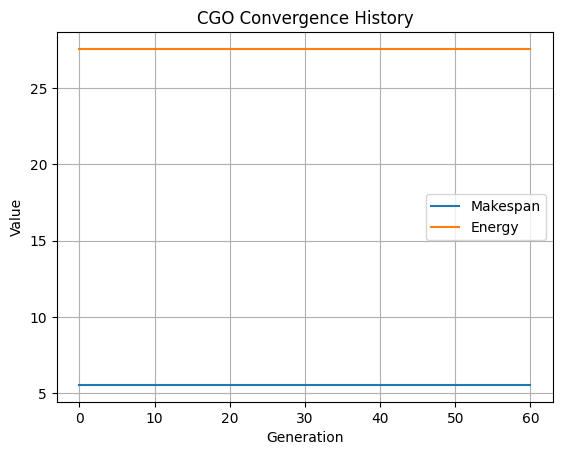

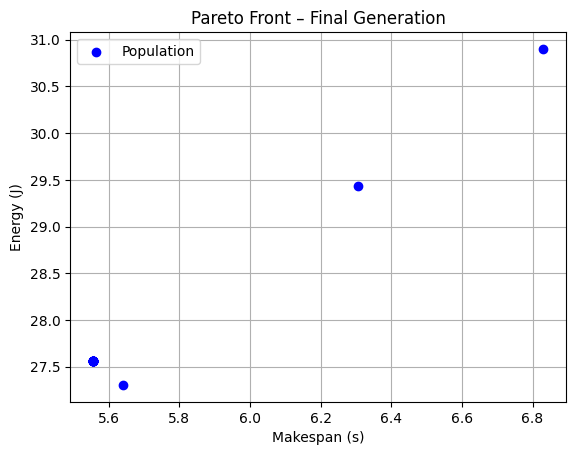

In [27]:
import random
from copy import deepcopy
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

"""
=====================================================================
Chaos‑Game‑Optimization‑based Multi‑Objective Scheduler (refactored)
---------------------------------------------------------------------
✓ Fixes convergence‑history bug (was plotting a flat line)
✓ Stores full (start,end) so we can draw a true Gantt chart
✓ Explains a,b,c Dirichlet coefficients & Mean‑Group selection
✓ Adds DAG visualisation helper
=====================================================================
"""

# ------------------------------  CONFIG  ----------------------------- #
NUM_TASKS = 6
NUM_NODES = 3
POP_SIZE   = 20   # number of seeds
MAX_GEN    = 60   # CGO iterations
MUTATE_P   = 0.15 # probability that a task changes node during mutation

# ----------  DAG  (task size in MI, parents list, optional data size MB)
# -------------------------------------------------------------------- #
tasks: Dict[int, Dict] = {
    0: {"size": 30, "parents": []},
    1: {"size": 25, "parents": [0]},
    2: {"size": 35, "parents": [0]},
    3: {"size": 20, "parents": [1]},
    4: {"size": 15, "parents": [1, 2]},
    5: {"size": 10, "parents": [3, 4]},
}

DEFAULT_DATA_MB = 5.0

# ----------  Nodes  (MIPS, base, active, idle power‑W)  --------------- #
NODES: List[Dict] = [
    {"id": 0, "mips": 20, "p_base": 0.5, "p_act": 2.0, "p_idle": 0.30},
    {"id": 1, "mips": 25, "p_base": 0.6, "p_act": 2.4, "p_idle": 0.35},
    {"id": 2, "mips": 40, "p_base": 0.8, "p_act": 3.0, "p_idle": 0.40},
]

# ----------  Network  (bandwidth Mbps, propagation ms)  --------------- #
BW   = np.array([[0, 50, 30],
                [50, 0, 25],
                [30, 25,  0]], dtype=float)
PROP = np.array([[0, 2, 5],
                [2, 0, 3],
                [5, 3, 0]], dtype=float)

# --------------------------------------------------------------------- #
#  Helper Functions
# --------------------------------------------------------------------- #

def comm_delay(src: int, dst: int, data_mb: float = DEFAULT_DATA_MB) -> float:
    """Return communication delay in seconds between two nodes."""
    if src == dst:
        return 0.0
    bw       = BW[src, dst]          # Mbps
    prop_ms  = PROP[src, dst]        # ms
    bw_time  = (data_mb * 8) / bw    # seconds (MB → Mb → time)
    return bw_time + prop_ms / 1_000


def topo_order(dag: Dict[int, Dict]) -> List[int]:
    g = nx.DiGraph()
    g.add_nodes_from(dag.keys())
    for t, info in dag.items():
        for p in info["parents"]:
            g.add_edge(p, t)
    return list(nx.topological_sort(g))

ORDER = topo_order(tasks)


def exec_time(task: int, node: int) -> float:
    """Execution time (s) = MillionInstructions / MIPS"""
    return tasks[task]["size"] / NODES[node]["mips"]


# --------------------------------------------------------------------- #
#  HEFT Ranking  (for semi‑greedy seed generation)
# --------------------------------------------------------------------- #

def upward_rank(task: int, cache: Dict[int, float]) -> float:
    if task in cache:
        return cache[task]
    avg_mips = np.mean([n["mips"] for n in NODES])
    w_i = tasks[task]["size"] / avg_mips
    succ = [c for c in tasks if task in tasks[c]["parents"]]
    if not succ:
        cache[task] = w_i
    else:
        cache[task] = w_i + max(upward_rank(s, cache) for s in succ)
    return cache[task]


def heft_order() -> List[int]:
    cache: Dict[int, float] = {}
    ranked = sorted(tasks.keys(), key=lambda t: -upward_rank(t, cache))
    return ranked

RANKED = heft_order()

# --------------------------------------------------------------------- #
#  Schedule & Evaluation
# --------------------------------------------------------------------- #

def schedule_individual(mapping: List[int]) -> Tuple[Dict[int, Tuple[int, float, float]], float, float]:
    """Return {task: (node,start,end)}, makespan, energy"""
    node_avail = [0.0] * NUM_NODES  # next‑free‑time per node
    task_info  = {}

    for task in ORDER:
        node = mapping[task]
        # Earliest ready time due to parents & comm
        ready = 0.0
        for p in tasks[task]["parents"]:
            p_node, p_start, p_end = task_info[p]
            d_mb = tasks[task].get("data", {}).get(p, DEFAULT_DATA_MB)
            ready = max(ready, p_end + comm_delay(p_node, node, d_mb))
        start = max(node_avail[node], ready)
        end   = start + exec_time(task, node)
        task_info[task] = (node, start, end)
        node_avail[node] = end

    makespan = max(node_avail)

    # Energy per node
    energy = 0.0
    for n in range(NUM_NODES):
        active = sum((info[2] - info[1]) for info in task_info.values() if info[0] == n)
        idle   = makespan - active
        e_base   = NODES[n]["p_base"] * makespan
        e_active = NODES[n]["p_act"]  * active
        e_idle   = NODES[n]["p_idle"] * idle
        energy  += e_base + e_active + e_idle

    return task_info, makespan, energy


# --------------------------------------------------------------------- #
#  Initial Population  (semi‑greedy HEFT)
# --------------------------------------------------------------------- #

def initial_population() -> List[List[int]]:
    pop = []
    for _ in range(POP_SIZE):
        mapping = [None] * NUM_TASKS
        for t in RANKED:
            mapping[t] = random.randrange(NUM_NODES)
        pop.append(mapping)
    return pop


# --------------------------------------------------------------------- #
#  CGO  (multi‑objective)
# --------------------------------------------------------------------- #

def scalar_fitness(values: List[Tuple[float, float]]) -> np.ndarray:
    """Normalised linear scalarisation of (makespan,energy)."""
    m = np.array([v[0] for v in values])
    e = np.array([v[1] for v in values])
    m_norm = (m - m.min()) / (m.max() - m.min() + 1e-9)
    e_norm = (e - e.min()) / (e.max() - e.min() + 1e-9)
    return m_norm + e_norm


def triangle_operator(xl: List[int], gb: List[int], mg: List[int]) -> List[int]:
    """Chaos Game triangle operator with Dirichlet coefficients."""
    a, b, c = np.random.dirichlet([1, 1, 1])  # a+b+c = 1
    new = []
    for i in range(NUM_TASKS):
        val = a * xl[i] + b * gb[i] + c * mg[i]
        new.append(int(round(val)))
    # mutation for diversity
    if random.random() < MUTATE_P:
        t_mut = random.randrange(NUM_TASKS)
        new[t_mut] = random.randrange(NUM_NODES)
    # clipping
    return [min(max(v, 0), NUM_NODES-1) for v in new]


def mean_group(pop: List[List[int]], exclude_idx: int) -> List[int]:
    """Return mean‑vector of a random half of population (including xl)."""
    indices = list(range(len(pop)))
    random.shuffle(indices)
    k = len(pop) // 2
    subset = indices[:k]
    if exclude_idx not in subset:
        subset[0] = exclude_idx  # ensure xl in subset
    subset_vec = np.mean([pop[i] for i in subset], axis=0)
    return [int(round(v)) for v in subset_vec]


def cgo() -> Tuple[List[int], List[Tuple[float,float]], List[List[int]]]:
    pop = initial_population()
    schedules = [schedule_individual(ind) for ind in pop]
    fitness   = [ (m,e) for _,m,e in schedules ]
    fit_vals  = scalar_fitness(fitness)
    gb_idx    = int(np.argmin(fit_vals))
    GB        = deepcopy(pop[gb_idx])
    best_scalar = fit_vals[gb_idx]
    history: List[Tuple[float,float]] = [fitness[gb_idx]]

    for gen in range(MAX_GEN):
        new_pop = []
        for i, xl in enumerate(pop):
            mg = mean_group(pop, i)
            child = triangle_operator(xl, GB, mg)
            new_pop.append(child)

        # Evaluate
        pop = new_pop
        schedules = [schedule_individual(ind) for ind in pop]
        fitness   = [ (m,e) for _,m,e in schedules ]
        fit_vals  = scalar_fitness(fitness)

        # update GB if we found better scalar fitness
        new_gb_idx = int(np.argmin(fit_vals))

        if fit_vals[new_gb_idx] < best_scalar:
            GB = deepcopy(pop[new_gb_idx])
            best_scalar = fit_vals[new_gb_idx]

        history.append(schedule_individual(GB)[1:3])

    return GB, history, pop


# --------------------------------------------------------------------- #
#  Visualisation Helpers
# --------------------------------------------------------------------- #

def plot_convergence(history: List[Tuple[float,float]]):
    gens = np.arange(len(history))
    m = [h[0] for h in history]
    e = [h[1] for h in history]
    plt.figure()
    plt.plot(gens, m, label="Makespan")
    plt.plot(gens, e, label="Energy")
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.title("CGO Convergence History")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_gantt(task_info: Dict[int, Tuple[int,float,float]]):
    colors = plt.cm.tab10.colors
    fig, ax = plt.subplots(figsize=(8,3))
    for task, (node,start,end) in task_info.items():
        ax.barh(y=node, width=end-start, left=start, height=0.6, color=colors[task%10], edgecolor='k')
        ax.text(start+(end-start)/2, node, f"T{task}", va='center', ha='center', color='white', fontsize=8)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Node")
    ax.set_yticks(range(NUM_NODES))
    ax.set_title("Schedule Gantt Chart")
    ax.grid(True, axis='x')
    plt.tight_layout()
    plt.show()


def draw_dag():
    g = nx.DiGraph()
    g.add_nodes_from(tasks.keys())
    for t, info in tasks.items():
        for p in info["parents"]:
            g.add_edge(p,t)
    pos = nx.spring_layout(g, seed=42)
    nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, arrowsize=15)
    plt.title("Task DAG")
    plt.show()
def plot_pareto_front(pop: List[List[int]]):
    points = [schedule_individual(ind)[1:3] for ind in pop]
    mks, engs = zip(*points)

    plt.figure()
    plt.scatter(mks, engs, c='blue', label='Population')
    plt.xlabel("Makespan (s)")
    plt.ylabel("Energy (J)")
    plt.title("Pareto Front – Final Generation")
    plt.grid(True)
    plt.legend()
    plt.show()


# --------------------------------------------------------------------- #
#  Demo
# --------------------------------------------------------------------- #
if __name__ == "__main__":
    best_mapping, history, _ = cgo()
    best_sched, best_m, best_e = schedule_individual(best_mapping)

    for task, (node, start, end) in sorted(best_sched.items()):
      print(f"Task {task}: Node {node} | Start {start:.2f}s | End {end:.2f}s")

    print(f"Makespan = {best_m:.3f} s, Energy = {best_e:.3f} J")

    draw_dag()
    plot_gantt(best_sched)
    plot_convergence(history)
    plot_pareto_front(_)
